# Placa 2D Elastoestática

Notebook feito com base em:  
* **Artigo:** Haghighat etal (2021) - *A physics-informed deep learning framework for inversion and surrogate modeling in solid mechanics*. DOI: [https://doi.org/10.1016/j.cma.2021.113741](https://doi.org/10.1016/j.cma.2021.113741)

**Notebook por:** Paulo de Souza Silva  
**Data:** Maio/Junho de 2025

**IGNORE ESTE CÓDIGO INICIAL**

* Se a figura da viga não aparecer, basta rodá-lo.

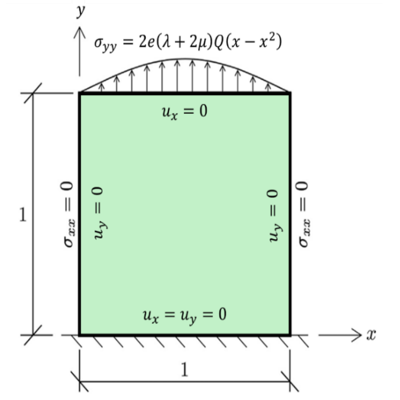

In [1]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1RPiHBCqpVu7QivKuR37XXPHaWoOi3-Zn'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (400, 400)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)

A placa 2D definida na figura é caracterizada como um cenário de um problema de Elasticidade Linear, em que o formalismo com simbolismo tensorial é dado por:

$$\begin{aligned}
\sigma_{ij,j} + f_i & = 0 \\
\sigma_{ij} & = \lambda \delta_{ij} \varepsilon_{kk} + 2\mu \varepsilon_{ij} \\
\varepsilon_{ij} & = \frac{1}{2} (u_{i,j} + u_{j,i})
\end{aligned}$$

Ao abrir essas equações temos para a **primeira equação**:
$$\frac{\partial \sigma_{xx}}{\partial x} + \frac{\partial \sigma_{xy}}{\partial y} + f_x= 0, \quad
\frac{\partial \sigma_{xy}}{\partial x} + \frac{\partial \sigma_{yy}}{\partial y} + f_y= 0,$$

para a **segunda:**
$$\sigma_{xx} = (\lambda + 2\mu)\epsilon_{xx} + \lambda\epsilon_{yy}, \quad
\sigma_{yy} = (\lambda + 2\mu)\epsilon_{yy} + \lambda\epsilon_{xx}, \quad
\sigma_{xy} =  2\mu\epsilon_{xy},$$

para a **última**
$$\epsilon_{xx} = \frac{\partial u_{x}}{\partial x}, \quad
\epsilon_{yy} = \frac{\partial u_{y}}{\partial y}, \quad
\epsilon_{xy} = \frac{1}{2}(\frac{\partial u_{x}}{\partial y} + \frac{\partial u_{y}}{\partial x}).$$



Nesse contexto, o domínio é definido por:
$$x \in [0, 1], \quad y \in [0, 1]$$

As forças de corpo são:
$$
\begin{split}
f_x & = -2 Q \lambda y \left( 1 - 2 x \right) \exp(y^2) \\
    & + \mu \left( -2 Q y \left( 1 - 2 x \right)  \exp(y^2) + \pi^2 \sin(\pi y) \right)
\end{split}
$$
e
$$
\begin{split}
f_y & = \lambda \left( -4 Q y^2 \left( -x^2 + x \right) \exp(y^2)- 2 Q \left( -x^2 + x \right) \exp(y^2) \right) \\
    & + \mu \left( -8 Q y^2 \left( -x^2 + x \right) \exp(y^2) - 4 Q \left( -x^2 + x \right) \exp(y^2) + 2 Q \exp(y^2) \right)
\end{split}
$$

As definições para os deslocamentos no contorno são:
$$u_x(x, 0) = u_x(x, 1) = 0,\\ u_y(0, y) = u_y(1, y) = u_y(x, 0) = 0,$$

e as condições de *traction*
$$\sigma_{xx}(0, y)=0, \quad \sigma_{xx}(1, y)=0, \quad \sigma_{yy}(x, 1)=2e(\lambda + 2\mu)Q(x-x^2)$$

Os parâmetros ainda são definidos: $\lambda = 1, \mu = 0.5,$ e $Q = 4$.

Sendo a solução exata do problema:
$$u_x(x, y) = \sin(\pi y) \\ u_y(x, y) = Qexp(y^2)(x-x^2)$$



## Começo do Código

**instalacoes**

O SciANN não funciona com as versões atuais do TensorFlow e do Keras, portanto é necessário:
1. Desinstalar as duas bibliotecas (keras e tensorflow)
2. Reinstalar com uma versão anterior compatível (por exemplo a 2.12)
3. Instalar o SciANN

**rodar o bloco a seguir duas vezes**
1. Normalmente ocorre um pequeno erro e é necessário reiniciar o ambiente
2. Após reiniciar o ambiente, rode novamente esse bloco e as instalações serão completadas

In [2]:
! pip uninstall -y keras tensorflow
! pip install tensorflow==2.12
! pip install sciann

Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 10.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sciann as sn
from sciann.utils.math import diff, sign, sin, sqrt
from sciann import Functional, Parameter, Variable, SciModel, Data, Tie

## OBSERVAÇÕES SOBRE A SOLUÇÃO

Apesar do problema ser o mesmo que o discutido com o DeepXDE, a forma que vamos resolvê-lo é diferente:
* **Não vamos** definir **condições de contorno**
* **Vamos** nos basear quase que puramente nos **dados** da **solução analítica**  (pense isso como um teste de laboratório onde é possível saber algumas informações
  * Sabemos $u_x, u_y, \sigma_x, \sigma_y, \sigma_{xy}, f_x$ e $f_y$ em ''alguns'' pontos
* Esta é uma PINN hibrida

Além disso, vamos tentar garantir via rede que a física é obdecida levando em consideração:

$$\sigma = \mathbf{C} \varepsilon$$

ou de forma explicita:
$$ \begin{aligned}
\sigma_{xx} &= C_{11}\epsilon_x + C_{12}\epsilon_y \\
\sigma_{yy} &= C_{21}\epsilon_x + C_{22}\epsilon_y \\
\sigma_{xy} &= C_{33}\epsilon_{xy}
\end{aligned}
$$


**parametros do problema**

In [3]:
# Parâmetros do material (Lame)
lmbd = 1.0
mu = 0.5
Q = 4.0
e = np.e

### Soluções exatas e equações do problema

In [4]:
def load(xx):
    x, y = xx[0], xx[1]
    return 2 * e * (lmbd + 2*mu) * Q * (x - x**2)

**força de corpo $f_x$**
$$
\begin{split}
f_x & = -2 Q \lambda y \left( 1 - 2 x \right) \exp(y^2) \\
    & + \mu \left( -2 Q y \left( 1 - 2 x \right)  \exp(y^2) + \pi^2 \sin(\pi y) \right)
\end{split}
$$

**Nota:** O notebook original troca o sinal das funções de corpo, para não ocasionar nenhum problema isso se manteve; é importante notar que na definição da PDE o sinal também está trocado, o que coincide com a teoria.

In [5]:
def bodyfx(xx):
    x, y = xx[0], xx[1]
    frc = -2*Q*lmbd*y*(1-2*x)*np.exp(y**2) + mu*(-2*Q*y*(1-2*x)*np.exp(y**2) + (np.pi**2)*np.sin(np.pi*y))
    return frc


**força de corpo $f_y$**  
$$
\begin{split}
f_y & = \lambda \left( -4 Q y^2 \left( -x^2 + x \right) \exp(y^2)- 2 Q \left( -x^2 + x \right) \exp(y^2) \right) \\
    & + \mu \left( -8 Q y^2 \left( -x^2 + x \right) \exp(y^2) - 4 Q \left( -x^2 + x \right) \exp(y^2) + 2 Q \exp(y^2) \right)
\end{split}
$$

In [6]:
def bodyfy(xx):
    x, y = xx[0], xx[1]
    frc = lmbd*(-4*Q*(y**2)*(-(x**2)+x)*np.exp(y**2) - 2*Q*(-(x**2)+x)*np.exp(y**2))
    + mu*(-8*Q*(y**2)*(-(x**2)+x)*np.exp(y**2) - 4*Q*(-(x**2)+x)*np.exp(y**2) + 2*Q*np.exp(y**2))
    return frc

DESLOCAMENTOS
$$u_x(x, y) = \sin(\pi y) \\ u_y(x, y) = Qexp(y^2)(x-x^2)$$

In [7]:
def dispx(xx):
    x, y = xx[0], xx[1]
    return np.sin(np.pi * y)

def dispy(xx):
    x, y = xx[0], xx[1]
    return Q * np.exp(y**2)*(x - x**2)


**deformações**
$$\begin{aligned}
\epsilon_{xx} &= - 2 \pi \sin{\left(2 \pi x \right)} \sin{\left(\pi y \right)}\\
\epsilon_{yy} &= Q y^{3} \sin{\left(\pi x \right)} \\
\epsilon_{xy} &= \frac{1}{2} \left(\frac{\pi Q y^{4} \cos{\left(\pi x \right)}}{4} + \pi \cos{\left(2 \pi x \right)} \cos{\pi y }\right)
\end{aligned}
$$

In [8]:
def strainxx(xx):
    x, y = xx[0], xx[1]
    return 0 * x + 0 * y

def strainyy(xx):
    x, y = xx[0], xx[1]
    return Q * (x - x**2) * np.exp(y**2) * 2 * y

def strainxy(xx):
    x, y = xx[0], xx[1]
    return 0.5 * (np.pi * np.cos(np.pi * y) + Q * np.exp(y**2)*(1 - 2 * x))

**tensoes**
$$\sigma_{xx} = (\lambda + 2\mu)\epsilon_{xx} + \lambda\epsilon_{yy}, \quad
\sigma_{yy} = (\lambda + 2\mu)\epsilon_{yy} + \lambda\epsilon_{xx}, \quad
\sigma_{xy} =  2\mu\epsilon_{xy}$$


In [9]:
def stressxx(xx):
    return (lmbd+2*mu)*strainxx(xx) + lmbd*strainyy(xx)

def stressyy(xx):
    return (lmbd+2*mu)*strainyy(xx) + lmbd*strainxx(xx)

def stressxy(xx):
    return 2.0*mu*strainxy(xx)

### Configuracoes para a rede

A única diferença aqui para o notebook do DeepXDE é a possibilidade de estruturar a rede de forma **tradicional** ou **paralela**, isso pode ser habilitado atribuindo respectivamente `False` ou `True` para o comando `independent_networks`


In [10]:
# Configurações
config = {
    "layers": [40, 40, 40, 40, 40],  # Arquitetura da rede
    "activation": "tanh",
    "num_x": 30,                  # Pontos em x
    "num_y": 30,                  # Pontos em y
    "batch_size": 32,
    "epochs": 1000,
    "learning_rate": 0.01,
    "independent_networks": True,
    "dtype": "float64"
}

**criando o modelo**

COMANDO **`Tie`**
> Essa função funciona da seguinte forma; se temos a igualdade:
$$\sigma_{xx} = C_{11}\cdot \varepsilon_{xx} + C_{12} \cdot \varepsilon_{yy}$$  
logo queremos que nossa rede consiga satisfazer
$$\sigma_{xx} - C_{11}\cdot \varepsilon_{xx} - C_{12} \cdot \varepsilon_{yy} = 0$$  
A função Tie serve justamente para dizer ao modelo que um lado deve ser igual ao outro:  
$tie_1$ = `Tie`$(\sigma_{xx},C_{11}\cdot \varepsilon_{xx} + C_{12} \cdot \varepsilon_{yy})$  
e portanto usamos para Loss que $tie_1$ deve ser **zero**.


In [11]:
# ==============================================
# Definindo o Modelo SciANN
# ==============================================
def create_model():
    # Variáveis de entrada: coordenadas
    x = Variable("x", dtype=config["dtype"])
    y = Variable("y", dtype=config["dtype"])

    ############################################################################
    # Variaveis de saida: deslocamentos e tensões
    # Aqui o condicional existe para poder estruturar a rede com FNN ou PFNN
    if config["independent_networks"]:
        Ux = Functional("Ux", [x, y], config["layers"], config["activation"])
        Uy = Functional("Uy", [x, y], config["layers"], config["activation"])
        Sxx = Functional("Sxx", [x, y], config["layers"], config["activation"])
        Syy = Functional("Syy", [x, y], config["layers"], config["activation"])
        Sxy = Functional("Sxy", [x, y], config["layers"], config["activation"])
    else:
        Ux, Uy, Sxx, Syy, Sxy = Functional(
            ["Ux", "Uy", "Sxx", "Syy", "Sxy"],
            [x, y],
            config["layers"],
            config["activation"]
        ).split()
    ############################################################################
    # Parâmetros de Lame
    lame1 = lmbd
    lame2 = mu

    # Relações constitutivas
    C11 = (2*lame2 + lame1)
    C12 = lame1
    C33 = 2*lame2

    # Deformações
    Exx = diff(Ux, x)
    Eyy = diff(Uy, y)
    Exy = (diff(Ux, y) + diff(Uy, x)) * 0.5


    # Restrições físicas
    c1 = Tie(Sxx, Exx*C11 + Eyy*C12)  # sxx = C11*exx + C12*eyy
    c2 = Tie(Syy, Eyy*C11 + Exx*C12)  # syy = C11*eyy + C12*exx
    c3 = Tie(Sxy, Exy*C33)            # sxy = 2mu*exy

    # Equações de equilíbrio (momentum_x e momentum_y)
    Lx = diff(Sxx, x) + diff(Sxy, y)  # dsxx/dx + dsxy/dy + fx = 0
    Ly = diff(Sxy, x) + diff(Syy, y)  # dsxy/dx + dsyy/dy + fy = 0

    # Valores obtidos pela rede
    d1 = Data(Ux)  # u(x,y)
    d2 = Data(Uy)  # v(x,y)
    d3 = Data(Sxx)  # sxx
    d4 = Data(Syy)  # syy
    d5 = Data(Sxy)  # sxy

    ############################################################################
    ########################### Criando o modelo ############################
    # Definimos quem são os dados de entreada: x, y
    # Definimos quem são os nossos alvos:
    #    Consideramos os proprios valores de saida da rede: d1, d2, d3, d4 e d5
    #    Consideremos as restricoes fisicas e de equilibrio: c1, c2, c3, Lx e Ly
    model = SciModel(
        inputs=[x, y],
        targets=[d1, d2, d3, d4, d5, c1, c2, c3, Lx, Ly],
        loss_func="mse",
        optimizer="adam"
    )
    return model, (Ux, Uy, Sxx, Syy, Sxy)

Esse formato do `return` explicitando as componentes Ux, Uy etc é para facilitar na hora de acessar os resultados

In [ ]:
# Gerando o modelo
model, networks = create_model()
Ux, Uy, Sxx, Syy, Sxy = networks

**treinamento**

O formato do `input_data` é definido com o uso de alguns comandos menores:

* Criamos dois vetores um para x e outro para y, com formatos (1, Nx) e (1,Ny)
* Depois criamos uma malha com o `meshgrid`

Exemplo
```python
x = np.linspace(0, 1, 3)  # [0, 0.5, 1]
y = np.linspace(0, 1, 2)  # [0, 1]
X, Y = np.meshgrid(x, y)
```
Resultado
```text
X = [[0.  0.5 1. ],    Y = [[0. 0. 0.],
     [0.  0.5 1. ]]         [1. 1. 1.]]
```

O comando `flatten` vai achatar essas matrizes
```python
X.flatten()  # Saída: [0., 0.5, 1., 0., 0.5, 1.]
Y.flatten()  # Saída: [0., 0., 0., 1., 1., 1.]
```

In [ ]:
# Gerar dados de treinamento
xx = np.linspace(0, 1, config["num_x"])
yy = np.linspace(0, 1, config["num_y"])

X, Y = np.meshgrid(xx,yy)
input_data = [X.flatten()[:, None], Y.flatten()[:, None]]

# Dados de treinamento (valores exatos)
target_data = [
    dispx(input_data),     # Ux
    dispy(input_data),     # Uy
    stressxx(input_data),  # Sxx
    stressyy(input_data),  # Syy
    stressxy(input_data),  # Sxy
    'zeros',               # c1
    'zeros',               # c2
    'zeros',               # c3
    bodyfx(input_data),    # Lx
    bodyfy(input_data)     # Ly
]

In [ ]:
# Treinar
history = model.train(
    input_data,
    target_data,
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    learning_rate=config["learning_rate"],
    verbose=1
)



Total samples: 900 
Batch size: 32 
Total batches: 29 

Epoch 1/1000
29/29 [==============================] - 6s 14ms/step - batch: 14.0000 - size: 31.0345 - loss: 78.5284 - Ux_loss: 0.2641 - Uy_loss: 0.3876 - Sxx_loss: 4.9752 - Syy_loss: 6.4558 - Sxy_loss: 5.4299 - sub_loss: 2.9976 - sub_2_loss: 2.4637 - sub_3_loss: 2.4316 - add_4_loss: 41.7891 - add_5_loss: 11.3193 - lr: 0.0100 - time: 6.4756
Epoch 2/1000
29/29 [==============================] - 0s 12ms/step - batch: 14.0000 - size: 31.0345 - loss: 40.1286 - Ux_loss: 0.2057 - Uy_loss: 0.2683 - Sxx_loss: 6.2172 - Syy_loss: 3.9519 - Sxy_loss: 4.1777 - sub_loss: 2.0063 - sub_2_loss: 1.1355 - sub_3_loss: 1.3624 - add_4_loss: 16.1448 - add_5_loss: 4.6248 - lr: 0.0100 - time: 0.3423
Epoch 3/1000
29/29 [==============================] - 0s 11ms/step - batch: 14.0000 - size: 31.0345 - loss: 26.9763 - Ux_loss: 0.1686 - Uy_loss: 0.1863 - Sxx_loss: 4.1165 - Syy_loss: 3.9747 - Sxy_loss: 2.7235 - sub_loss: 1.4060 - sub_2_loss: 0.5728 - sub_3_los

# Gráficos

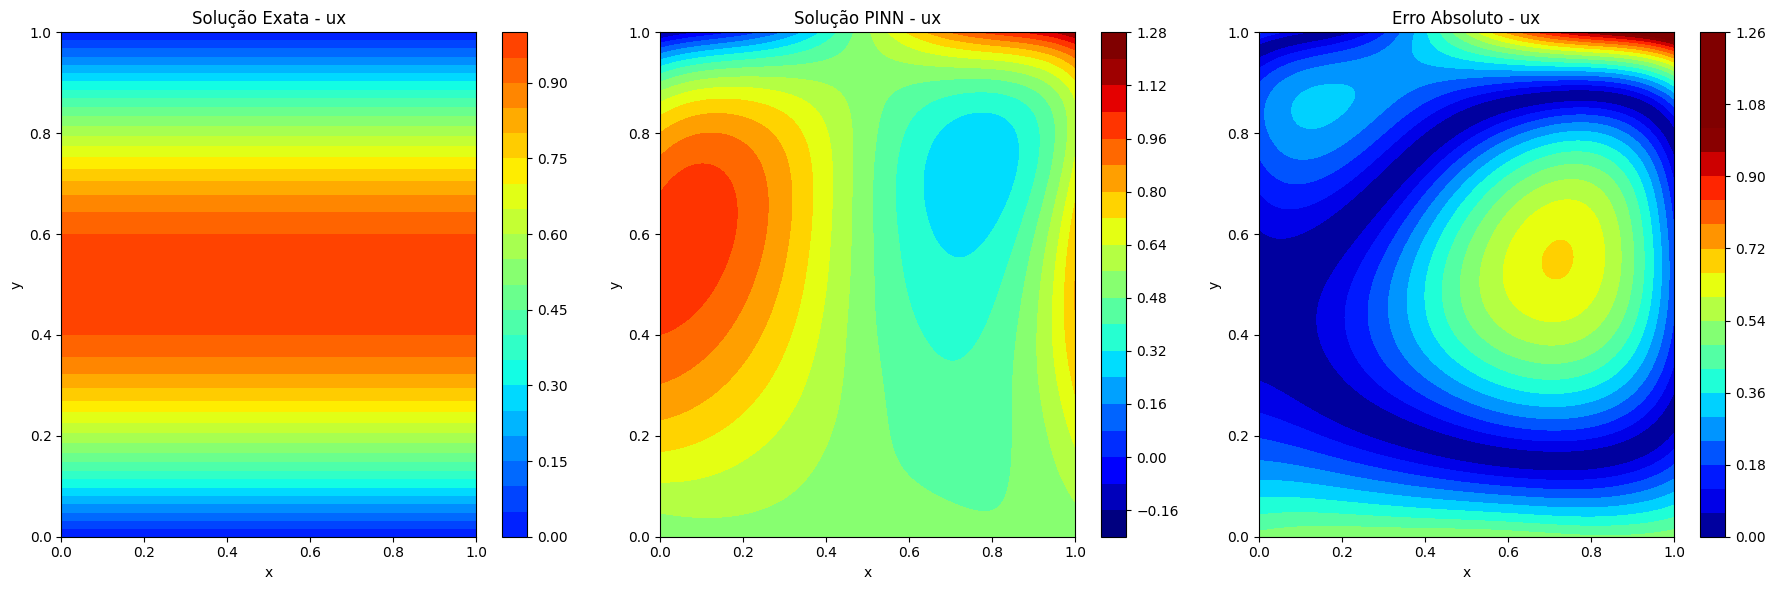

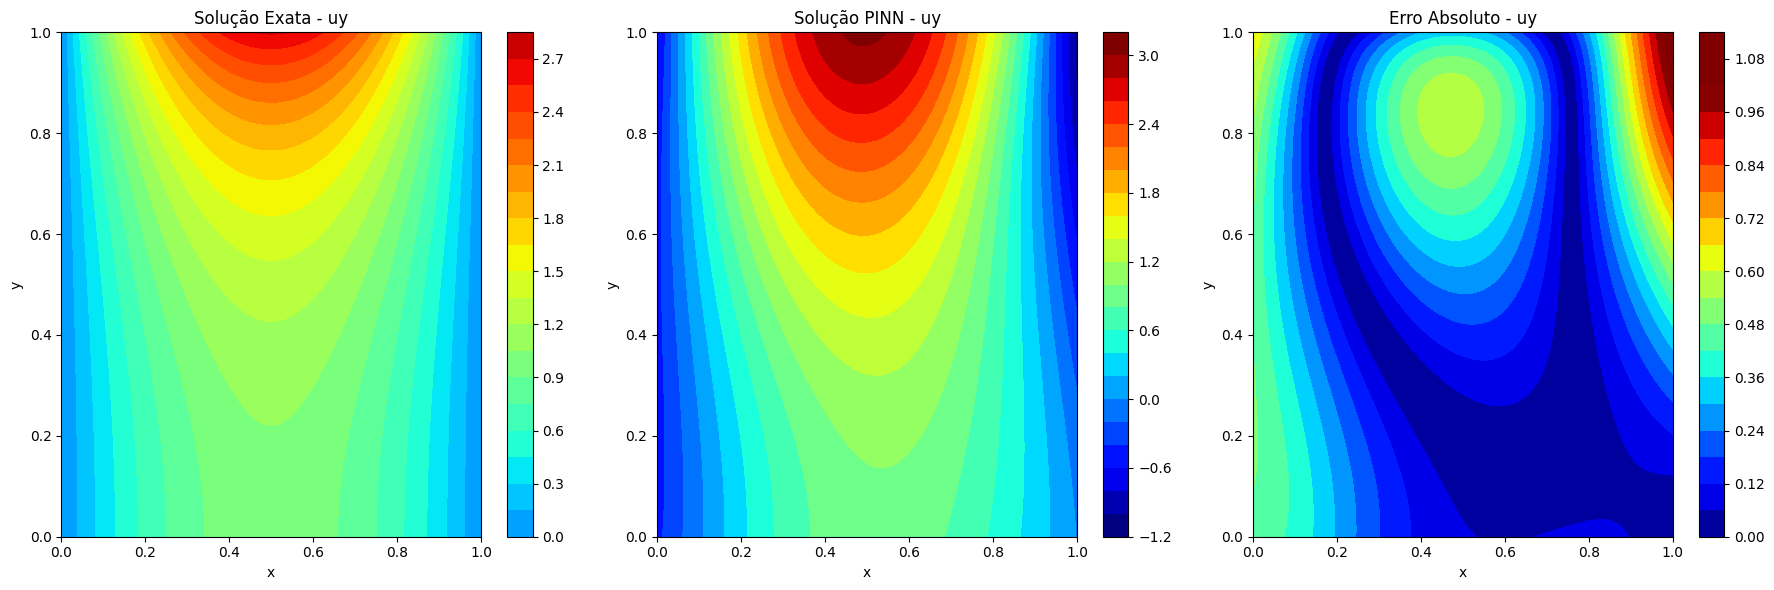

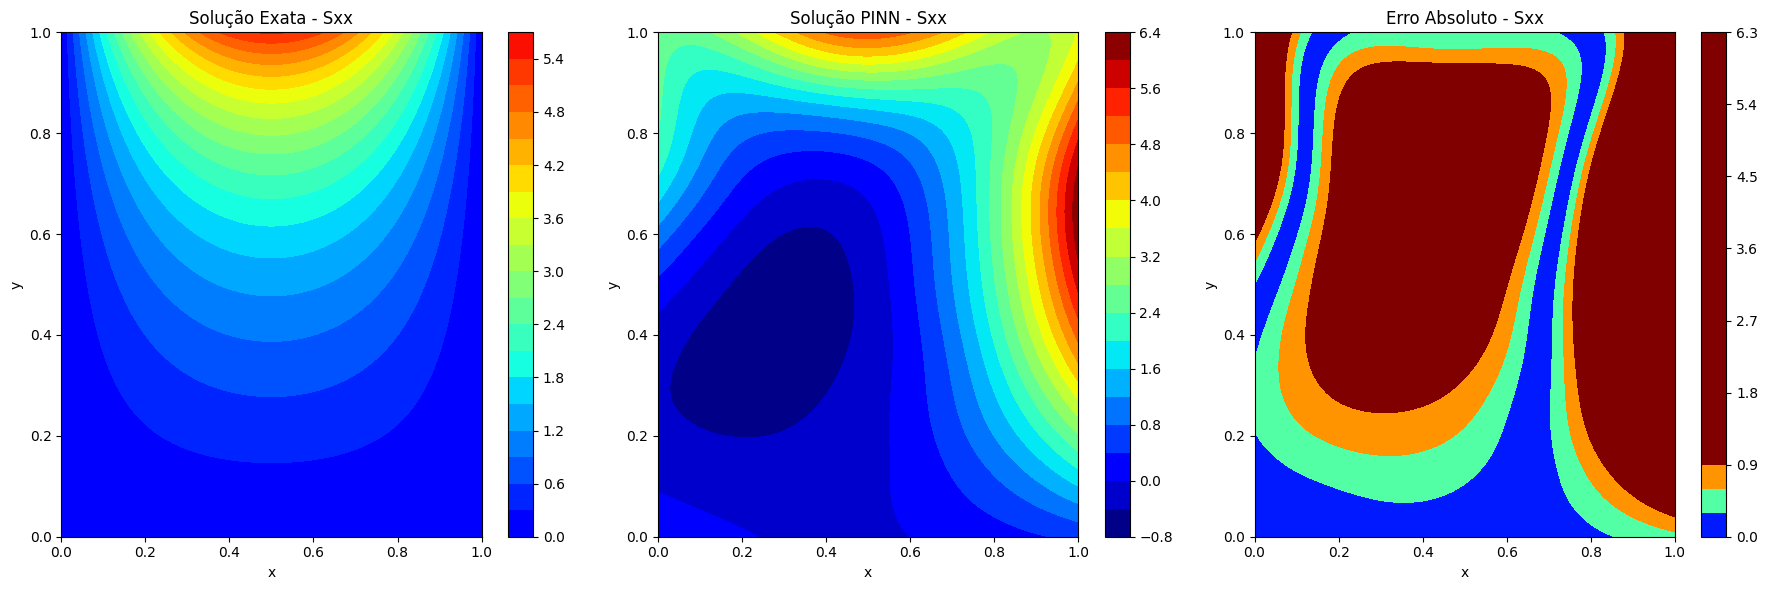

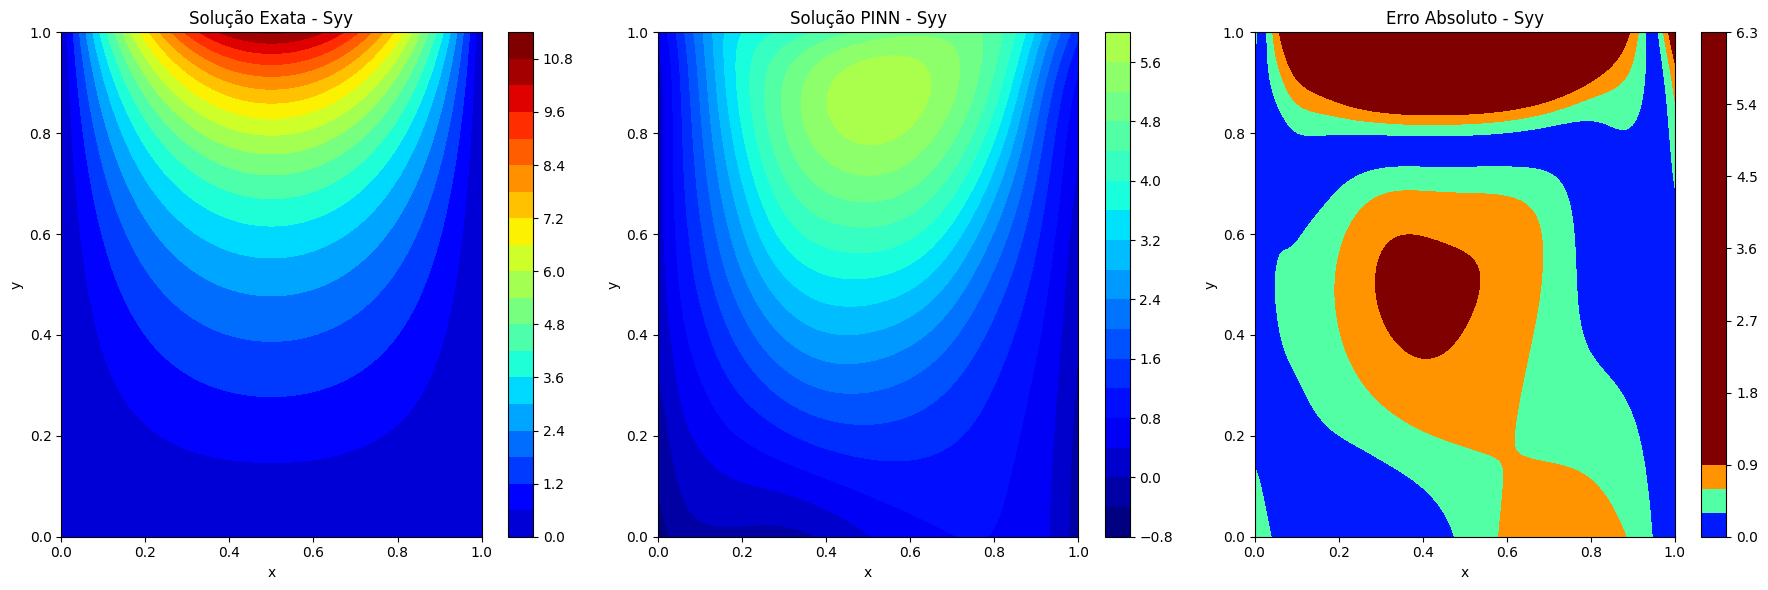

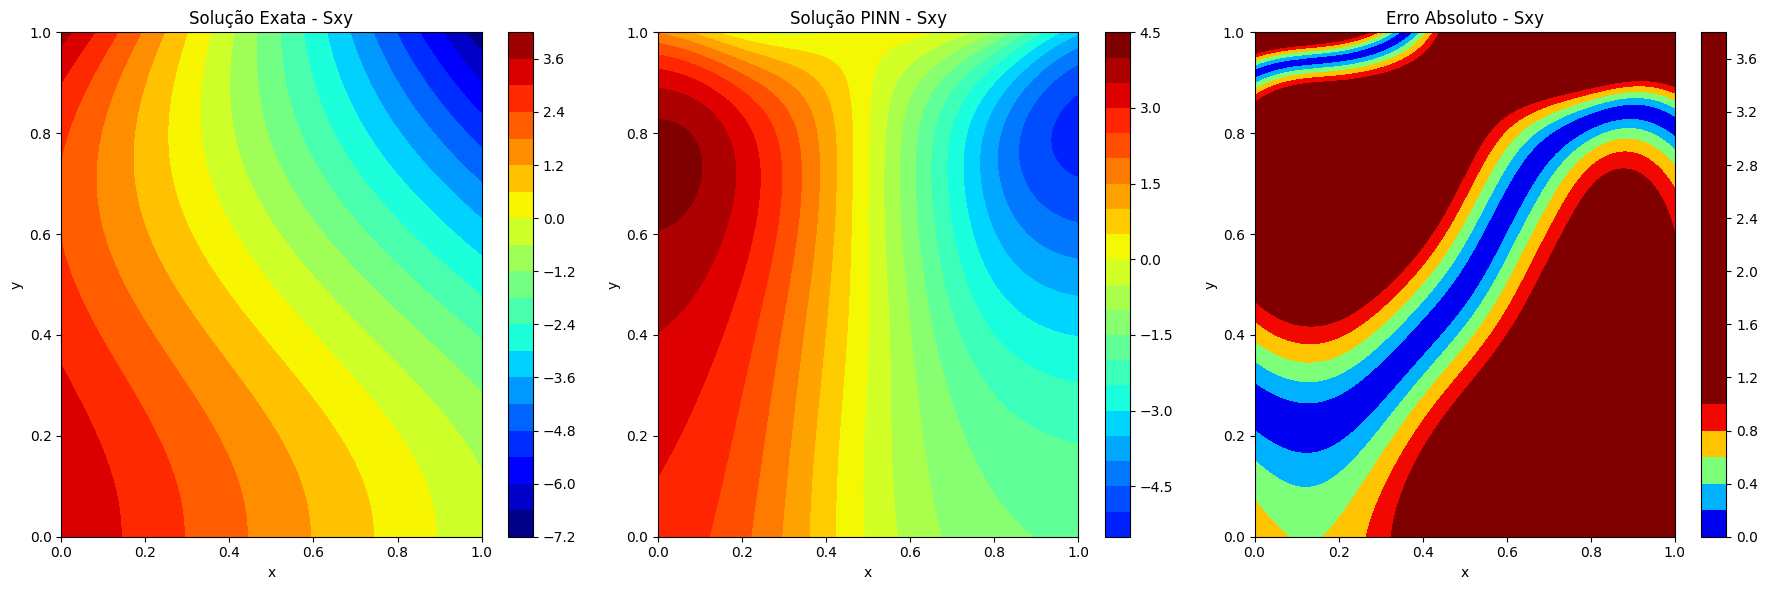

In [ ]:
# ===== Pós-processamento =====
# Gerar grade para plotagem
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
input_plot = [X.flatten()[:, None], Y.flatten()[:, None]]

# Predições
Ux_pred = Ux.eval(model, input_plot)
Uy_pred = Uy.eval(model, input_plot)
Sxx_pred = Sxx.eval(model, input_plot)
Syy_pred = Syy.eval(model, input_plot)
Sxy_pred = Sxy.eval(model, input_plot)

# Valores verdadeiros
ux_true = dispx(input_plot)
uy_true = dispy(input_plot)
sx_true = stressxx(input_plot)
sy_true = stressyy(input_plot)
sxy_true = stressxy(input_plot)

exact_solution = np.hstack((ux_true, uy_true, sx_true, sy_true, sxy_true))
predicted_solution = np.hstack((Ux_pred, Uy_pred, Sxx_pred, Syy_pred, Sxy_pred))

# Nomes das variáveis para plotagem
variables = ["ux", "uy", "Sxx", "Syy", "Sxy"]
num_vars = len(variables)

# Criar figuras para cada variável
for i in range(num_vars):
    plt.figure(figsize=(18, 6))
    vmin = min(np.min(exact_solution[:, i]), np.min(predicted_solution[:, i]))
    vmax = max(np.max(exact_solution[:, i]), np.max(predicted_solution[:, i]))

    # Plot solução exata
    plt.subplot(1, 3, 1)
    exact = exact_solution[:, i].reshape(100, 100)
    im = plt.contourf(X, Y, exact, levels=20, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"Solução Exata - {variables[i]}")
    plt.xlabel("x")
    plt.ylabel("y")

    # Plot solução PINN
    plt.subplot(1, 3, 2)
    pred = predicted_solution[:, i].reshape(100, 100)
    im = plt.contourf(X, Y, pred, levels=20, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"Solução PINN - {variables[i]}")
    plt.xlabel("x")
    plt.ylabel("y")

    # Plot erro absoluto
    plt.subplot(1, 3, 3)
    #error = np.sqrt(((exact - pred)**2)/100)
    error = np.abs(exact - pred)
    im = plt.contourf(X, Y, error, levels=20, cmap="jet", vmin=0, vmax=1)
    plt.colorbar(im)
    plt.title(f"Erro Absoluto - {variables[i]}")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.tight_layout()
    plt.show()



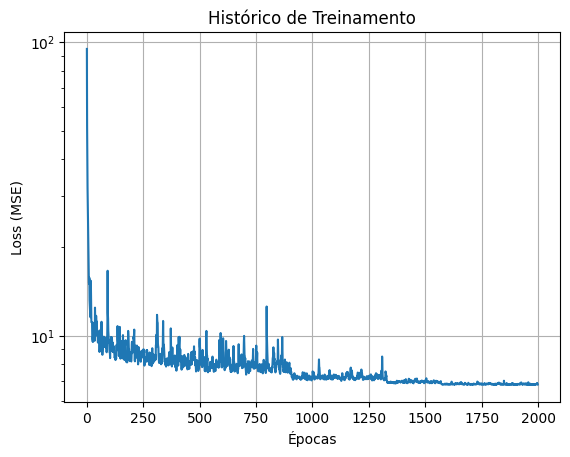

In [ ]:
#Plotar histórico de treinamento
plt.semilogy(history.history['loss'])
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.title("Histórico de Treinamento")
plt.grid()
plt.show()